tl;dr : *On essaie ici de deviner le transfert des voix entre les choix effectués entre deux scrutins d'un vote (ici les élections présidentielles 2022 en France) par une méthode d'[apprentissage automatique](https://fr.wikipedia.org/wiki/Apprentissage_automatique).*


[![DOI](https://zenodo.org/badge/488514016.svg)](https://zenodo.org/badge/latestdoi/488514016)


Afin d'analyser les résultats des élections, par exemple les dernières élections présidentielles de 2022 en France, et de mieux comprendre la dynamique des choix de vote entre les différents groupes de population, il peut être utile d'utiliser des outils d'[apprentissage automatique](https://fr.wikipedia.org/wiki/Apprentissage_automatique) pour inférer des structures à première vue cachées dans la masse des données. En particulier, inspiré par cet [article du Monde](https://www.lemonde.fr/les-decodeurs/article/2022/05/04/election-presidentielle-2022-quels-reports-de-voix-entre-les-deux-tours_6124672_4355770.html), on peut se poser la question de savoir *si on peut extraire depuis les données brutes des élections une estimation du report de voix entre les choix de vote au premier tour et ceux qui sont effectués au deuxième tour*.

Pour cela, parmi les outils mathématiques de l'apprentissage automatique, nous allons utiliser des probabilités. Cette théorie va nous permettre d'exprimer le fait que les résultats tels qu'ils sont obtenus peuvent présenter une variabilité mais que celle-ci réelle résulte de préférences de chaque individu dans la population votante. En particulier, on peut considérer que chaque individu va avoir une préférence, graduée entre $0=0\%$ et $1=100\%$ pour chacun des choix (candidats, nul, blanc, abstention) au premier et second tour. Ainsi, les votes effectués vont correspondre à la réalisation de ces préférences. 

Bien sûr, le vote reste secret et on n'a pas accès au vote de chaque individu et encore moins à ses préférences. Mais comme chaque bureau de vote présente des variabilités liées au contexte local et qui fait que cette population locale a une préférence pour certains choix plutôt que d'autres, on peut considérer chaque bureau de vote comme une population individuelle pour lequel nous allons essayer de prédire les résultats du vote au deuxième tour. **En exploitant les irrégularités locales, bureau de vote par bureau de vote, nous allons pouvoir prédire (le mieux possible) le report des votes individuel (de chaque individu tel qu'il passe d'un vote à un autre, par exemple de "Hidalgo" à "Macron").** Nous allons en particulier montrer une prédiction très correcte des données du second tour à partir de ceux du premier, montrant la plausibilité d'une telle hypothèse :

![Prédiction du transfert des voix](https://raw.githubusercontent.com/laurentperrinet/2022-05-04_transfert-des-voix/main/2022-06-08_prediction_transfert-des-voix_bce.png "Prédiction du transfert des voix")

C'est à ma connaissance une contribution originale (jusqu'à ce qu'une bonne âme veuille bien me donner un lien vers une méthode existante similaire qui me permette de correctement la citer...) que nous allons exploiter ici. Cette prédiction, si elle est efficace (et on va montrer qu'elle est en moyenne correctement prédite avec moins de 2 points de pourcentages d'erreur près), peut donner une idée du transfert de vote entre les deux tours qui a lieu en fonction des préférences des votes de chaque individu.

Nous allons dans la suite montrer comment on peut estimer le pourcentage de chances d'exprimer une voix pour un candidat ou pour l'autre en fonction du choix qu'on a exprimé au premier tour:

![Transfert des voix](https://raw.githubusercontent.com/laurentperrinet/2022-05-04_transfert-des-voix/main/2022-06-06_transfert-des-voix.png "Transfert des voix")

Comme on le verra plus bas, ce tableau montre des tendances claires, par exemple que si on a voté "Macron", "Jadot", "Hidalgo" ou "Pécresse" au premier tour, alors on va certainement voter "Macron" au deuxième tour. Ces électeurs se montrent particulièrement consensuels et suivent le « pacte républicain » mis en place pour faire un « barrage » au Front National (en suivant le terme consacré). Il montre aussi que si on a voté "Le Pen" ou "Dupont-Aignan" au premier tour alors on va voter Le Pen au deuxième, un clair vote de suivi.

Connaissant les couleurs politiques d'autres candidats du premier tour, on peut être surpris que les électeurs de "Arthaud", "Roussel", "Lassalle" ou "Poutou" ont majoritairement choisi "Le Pen" au deuxième tour, signifiant alors un rejet du candidat Macron. Les électeurs de Zemmour sont aussi partagés, signifiant un rejet des deux alternatives. **Ce résultat est à prendre avec des pincettes car ces derniers candidats ont obtenu moins de votes et donc que le processus d'inférence est forcément moins précis car il y a moins de données disponibles.** 

En résumé, cette analyse donne des tendances en fonction des choix exprimés au premier tour:

![Transfert des voix](https://raw.githubusercontent.com/laurentperrinet/2022-05-04_transfert-des-voix/main/2022-06-08_transfert-des-voix_tendances.png "Tendances présidentielle 2022")
qui montre une nette séparation des groupes de vote.

<!-- TEASER_END -->

Grâce à l'ouverture des données sur https://www.data.gouv.fr/ (notamment utilisées pour la recherche), on peut obtenir librement les résultats des [premier](https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour/) et [second](https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-2nd-tour/) tours. Il est intéressant de noter que les résultats donnés sont indiqués pour *chacun* des bureaux de vote. 

Nous allons faire deux hypothèses que nous allons expliciter mathématiquement : 

1. Tout d'abord, nous allons estimer que pour chaque individu, il existe une préférence pour les choix du premier tour ainsi que pour les choix du deuxième tour. 

 - On note par exemple les différentes alternatives au premier tour comme $i \in \{ \text{'Nul'}, \text{'Abstention'}, \ldots, \text{'Macron'}, \text{'Poutou'} \}$ et au deuxième tour  $j \in \{ \text{'Nul'}, \text{'Abstention'}, \ldots, \text{'Macron'}, \text{'Le Pen'} \}$. 
 
 - Le vote de chaque individu se modélise mathématiquement par un [processus de Bernoulli](https://fr.wikipedia.org/wiki/Processus_de_Bernoulli) relatif à ces préférences : on peut écrire pour chaque individu $k$ les probabilités de vote $p^k_i$ et $q^k_j$ (chacune de ces valeurs étant comprises entre $0$ et $1$ représentant un biais de probabilité pour chacune des alternatives). On pourra vérifier que $\forall k$ (pour tout individu), alors $\sum_i p^k_i = 1$ et $\sum_j q^k_j = 1$, ce qui revient à dire qu'à chaque scrutin un individu effectue un et un seul choix.
 
 - Avec une telle modélisation, on peut prédire les résultats du vote, car les préférences de chaque individu pour tel ou tel choix doit se révèle nécessairement au niveau de la population totale. Plus précisément, le théorème central limite indique que la moyenne observée (c'est-à-dire les moyennes de vote observées pour les différents choix) tend vers ces probabilités avec une précision (inverse de la variance) qui augmente linéairement avec le nombre d'observations. En particulier, les résultats des votes au premier et second tour seront donnés par respectivement $\frac 1 K \cdot \sum_k p^k_i$ et $\frac 1 K \cdot \sum_k q^k_j$ avec $K$ la taille de la population (nous vérifierons ce point plus bas).

2. Une deuxième hypothèse que nous allons faire et que si on considère la transition entre les préférences qui sont faites au premier tour et celles qui sont faites au second tour.

 - En effet, les préférences peuvent évoluer avec chaque invidu mais que la transition est homogène au sein de la population (par exemple "une personne qui choisit de s'abstenir s'abstiendra"). C'est une hypothèse *a priori* grossière, mais assez générale pour refléter les tendances au niveau de la population globale, et nous allons la tester. 

 - Cette hypothèse est basée sur la modélisation d'une séquence de deux événements aléatoires comme dans un [processus de Markov](https://fr.wikipedia.org/wiki/Cha%C3%AEne_de_Markov). En particulier, nous allons formaliser cette hypothèse en faisant l'hypothèse de l'existence d'une matrice de transition $M$ qui permet de prédire la préférence $\hat{q}^k_j$ d'un individu au second tour à partir de ses préférences au premier tour. Mathématiquement, cette hypothèse peut être formulée comme un simple produit matriciel :

$$
\hat{q}^k_j = \sum_i M_{i, j} \cdot p^k_i 
$$

En termes plus simples, cette formule exprime que la préférence d'un individu au second tour et le mélange de ses préférences individuelles au premier tour avec des poids indiquant les affinités entre les différentes alternatives aux deux tours. 

 - Il est important de noter qu'il existe une contrainte  pour chaque colonne de cette matrice de transition, de sorte que la somme des différents éléments sur les différentes lignes de la matrice pour chaque colonne est égale à $1$ : $\forall j$, $ \sum_i M_{i, j} = 1$. Cette propriété découle des contraintes de représentation des préférences au premier et au deuxième tour que nous avons évoquées plus haut ($\sum_i p^k_i = 1$ et $\sum_j q^k_j = 1$).

D'une certaine façon, cette matrice de transition décrit exactement les affinités de chacun des individus pour les différents choix de vote au niveau de la population globale. C'est donc un indicateur *quantitatif* des reports de vote qui vont être effectivement effectués entre les deux tours.

## Méthodes

### Calcul libre

Ce post est une exploration, un travail de recherche dont les méthodes essaient de suivre la méthode scientifique le plus fidélement possible:

 - À ce titre, il est écrit dans un format qui permet de reproduire *entièrement* les résultats: les données et les algorithmes sont librement disponibles: le format choisi est un [notebook jupyter](https://fr.wikipedia.org/wiki/Jupyter) avec le language python. Aussi, les librairies utilisées sont toutes open-source et donc utilisables librement.
 - De plus, nous avons consigné les différentes versions de ce post dans une "archive" github : https://github.com/laurentperrinet/2022-05-04_transfert-des-voix. Ceci permet de vérifier le cheminement (parfois tortueux) suivi pour arriver à des résultats qui semblent valides. 

### Collecte des données

La première partie de ce travail consiste à collecter les données et elle est représentée d'une façon utile. On va utiliser les données disponibles sur https://www.data.gouv.fr en se concentrant sur les résultats définitifs par bureau de vote. 
Commençons notre procédure avec le traitement des données du premier tour. Une fois que nous aurons décortiqué cette méthode, nous passerons au deuxième tour.

#### Données du premier tour

Pour cela nous allons utiliser deux premières librairies python : `numpy` pour le traitement de données numériques puis `pandas` pour la représentation de ces données sous forme de tableau tableaux.


In [1]:
datetime = '2022-06-08'
import numpy as np
import pandas as pd

On peut directement enregistrer à partir de l'adresse des données puis extraire ses données numériques depuis le tableau (en format "Excel (xlsx)") grâce a la [fonction suivante](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html):

In [2]:
import os

In [3]:
fname = '/tmp/T1.xlsx'

if not os.path.isfile(fname):
    url = 'https://static.data.gouv.fr/resources/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour/20220414-152612/resultats-par-niveau-burvot-t1-france-entiere.xlsx' # XLSX
    import urllib.request
    urllib.request.urlretrieve(url, fname)

T1 = pd.read_excel(fname)

On peut avoir une première idée de ces données et du nombre total de bureaux de vote :

In [4]:
T1.tail()

Code du département           Libellé du département  \
69677                  ZZ  Français établis hors de France   
69678                  ZZ  Français établis hors de France   
69679                  ZZ  Français établis hors de France   
69680                  ZZ  Français établis hors de France   
69681                  ZZ  Français établis hors de France   

       Code de la circonscription Libellé de la circonscription  \
69677                           6          6ème circonscription   
69678                          11         11ème circonscription   
69679                          11         11ème circonscription   
69680                           2          2ème circonscription   
69681                           2          2ème circonscription   

       Code de la commune Libellé de la commune Code du b.vote  Inscrits  \
69677                 229                Zurich           0001     24868   
69678                 231                Taipei           0001      1709   
69679                 233          Nour-Soultan           0001       117   
69680                 234             Monterrey           0001       713   
69681                 235      Bahamas (Nassau)           0001       136   

       Abstentions  % Abs/Ins  ...  Unnamed: 95  Unnamed: 96  Unnamed: 97  \
69677        14101      56.70  ...           47         0.19         0.44   
69678          942      55.12  ...           10         0.59         1.32   
69679           64      54.70  ...            0         0.00         0.00   
69680          553      77.56  ...            1         0.14         0.63   
69681           78      57.35  ...            0         0.00         0.00   

       Unnamed: 98  Unnamed: 99   Unnamed: 100  Unnamed: 101  Unnamed: 102  \
69677           12            M  DUPONT-AIGNAN       Nicolas           189   
69678           12            M  DUPONT-AIGNAN       Nicolas            10   
69679           12            M  DUPONT-AIGNAN       Nicolas             1   
69680           12            M  DUPONT-AIGNAN       Nicolas             1   
69681           12            M  DUPONT-AIGNAN       Nicolas             1   

       Unnamed: 103  Unnamed: 104  
69677          0.76          1.77  
69678          0.59          1.32  
69679          0.85          1.96  
69680          0.14          0.63  
69681          0.74          1.82  

[5 rows x 105 columns]

Les données sont organisées suivant des colonnes qui vont représenter les différents choix et aussi d'autres métadonnées. Il va falloir faire quelques recherches simples pour récupérer ces données utiles…

In [5]:
T1.columns

Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins',
       ...
       'Unnamed: 95', 'Unnamed: 96', 'Unnamed: 97', 'Unnamed: 98',
       'Unnamed: 99', 'Unnamed: 100', 'Unnamed: 101', 'Unnamed: 102',
       'Unnamed: 103', 'Unnamed: 104'],
      dtype='object', length=105)

Ainsi, la première colonne concerne les nuls, blancs et abstention, que l'on peut enregistrer dans un nouveau tableau :

In [6]:
df_1 = T1[['Nuls', 'Blancs', 'Abstentions']].copy()
df_1.head()

Nuls  Blancs  Abstentions
0     1      16          108
1     1       3           38
2     5      18          266
3     6      15          265
4     8      10          246

In [7]:
df_1

Nuls  Blancs  Abstentions
0         1      16          108
1         1       3           38
2         5      18          266
3         6      15          265
4         8      10          246
...     ...     ...          ...
69677    31      40        14101
69678     2       8          942
69679     0       2           64
69680     2       0          553
69681     0       3           78

[69682 rows x 3 columns]

#### Extraction des résultats de vote

Les 23 premières colonnes correspondent aux métadonnées :

In [8]:
T1.columns[:23]

Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau',
       'Sexe'],
      dtype='object')

Les colonnes suivant la colonne numéro 23 vont concerner les résultats candidat par candidat :

In [9]:
col_start = 23
col_par_cdt = 7

On peut extraire les noms des candidats présents au premier tour :

In [10]:
candidats = T1.iloc[0][col_start::col_par_cdt]
candidats

Nom                   ARTHAUD
Unnamed: 30           ROUSSEL
Unnamed: 37            MACRON
Unnamed: 44          LASSALLE
Unnamed: 51            LE PEN
Unnamed: 58           ZEMMOUR
Unnamed: 65         MÉLENCHON
Unnamed: 72           HIDALGO
Unnamed: 79             JADOT
Unnamed: 86          PÉCRESSE
Unnamed: 93            POUTOU
Unnamed: 100    DUPONT-AIGNAN
Name: 0, dtype: object

On peut par exemple extraire les résultats pour le premier bureau de vote et donner le nombre de suffrages exprimés pour chaque candidat :

In [11]:
résultats = T1.iloc[0][(col_start+2)::col_par_cdt]
résultats

Voix              3
Unnamed: 32       6
Unnamed: 39     150
Unnamed: 46      18
Unnamed: 53     149
Unnamed: 60      43
Unnamed: 67      66
Unnamed: 74       5
Unnamed: 81      30
Unnamed: 88      26
Unnamed: 95       3
Unnamed: 102     21
Name: 0, dtype: object

Grâce à ces connaissances, nous pouvons maintenant récolter les données pour chaque candidat et pour tous les bureaux de vote en utilisant la fonction suivante :

In [12]:
for i_candidat, candidat in enumerate(candidats):
    i_col = col_start + i_candidat*col_par_cdt + 2
    print('# colonne', i_col, ' résultats=', T1.iloc[:, i_col].values)
    df_1[candidat] = T1.iloc[:, i_col].values

# colonne 25  résultats= [3 2 4 ... 0 0 0]
# colonne 32  résultats= [ 6  7 30 ...  1  1  1]
# colonne 39  résultats= [150  50 159 ...  25  96  25]
# colonne 46  résultats= [18 10 24 ...  1  1  0]
# colonne 53  résultats= [149  23 237 ...   3   4   3]
# colonne 60  résultats= [43 14 69 ...  7 18 17]
# colonne 67  résultats= [ 66  41 216 ...   9  19   2]
# colonne 74  résultats= [ 5  3 15 ...  0  2  0]
# colonne 81  résultats= [30 10 25 ...  4 10  0]
# colonne 88  résultats= [26  8 40 ...  0  5  6]
# colonne 95  résultats= [3 3 8 ... 0 1 0]
# colonne 102  résultats= [21  0 13 ...  1  1  1]


Nous avons récolté les données utiles dans un nouveau tableau :

In [13]:
print(df_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69682 entries, 0 to 69681
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Nuls           69682 non-null  int64
 1   Blancs         69682 non-null  int64
 2   Abstentions    69682 non-null  int64
 3   ARTHAUD        69682 non-null  int64
 4   ROUSSEL        69682 non-null  int64
 5   MACRON         69682 non-null  int64
 6   LASSALLE       69682 non-null  int64
 7   LE PEN         69682 non-null  int64
 8   ZEMMOUR        69682 non-null  int64
 9   MÉLENCHON      69682 non-null  int64
 10  HIDALGO        69682 non-null  int64
 11  JADOT          69682 non-null  int64
 12  PÉCRESSE       69682 non-null  int64
 13  POUTOU         69682 non-null  int64
 14  DUPONT-AIGNAN  69682 non-null  int64
dtypes: int64(15)
memory usage: 8.0 MB
None


Une fois ce nouveau tableau comilé, ceci nous permet par exemple d'extraire les résultats pour un candidat donné et pour chacun des bureaux de vote (indexé dans l'ordre du fichier) :

In [14]:
df_1['POUTOU']

0         3
1         3
2         8
3         4
4         3
         ..
69677    47
69678    10
69679     0
69680     1
69681     0
Name: POUTOU, Length: 69682, dtype: int64

En particulier, on a le nombre suivant de bureaux de vote :

In [15]:
len(df_1)

69682

Et on peut calculer pour chaque alternative le nombre total de choix ainsi que le nombre total de choix dans les data:

In [16]:
df_1.sum(), df_1.sum().sum()

(Nuls               247151
 Blancs             543609
 Abstentions      12824169
 ARTHAUD            197094
 ROUSSEL            802422
 MACRON            9783058
 LASSALLE          1101387
 LE PEN            8133828
 ZEMMOUR           2485226
 MÉLENCHON         7712520
 HIDALGO            616478
 JADOT             1627853
 PÉCRESSE          1679001
 POUTOU             268904
 DUPONT-AIGNAN      725176
 dtype: int64,
 48747876)

Par exemple, on note qu'environ 13 millions de personnes se sont abstenues, alors que environ 10 millions de personnes ont voté pour Macron.

Dans le reste, nous pourrions aussi complétement ignorer les votes 'Nuls' et 'Abstentions'. En effet, durant nos expériences (cf github) nous avons pu obtenir des modèles pour lesquelles ces valeurs étaient moins prédictibles. Dans le cadre d'un "débogage", on peut vouloir enlever certaines colonnes. Pour cela, nous utilisons la fonction [`DataFrame.drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html):

In [17]:
df_1.columns

Index(['Nuls', 'Blancs', 'Abstentions', 'ARTHAUD', 'ROUSSEL', 'MACRON',
       'LASSALLE', 'LE PEN', 'ZEMMOUR', 'MÉLENCHON', 'HIDALGO', 'JADOT',
       'PÉCRESSE', 'POUTOU', 'DUPONT-AIGNAN'],
      dtype='object')

Dans ce post, nous ne l'avons pas fait, mais il suffit de décommenter la ligne suivante pour impacter le reste des calculs:

In [18]:
# df_1 = df_1.drop(columns=['Nuls', 'Blancs'])#, 'Abstentions'])

In [19]:
df_1.columns

Index(['Nuls', 'Blancs', 'Abstentions', 'ARTHAUD', 'ROUSSEL', 'MACRON',
       'LASSALLE', 'LE PEN', 'ZEMMOUR', 'MÉLENCHON', 'HIDALGO', 'JADOT',
       'PÉCRESSE', 'POUTOU', 'DUPONT-AIGNAN'],
      dtype='object')

Sous un format graphique on peut représenter ainsi les résultats du vote au premier tour et pour cela nous allons utiliser la librairie `matplotlib`:

In [20]:
import matplotlib.pyplot as plt

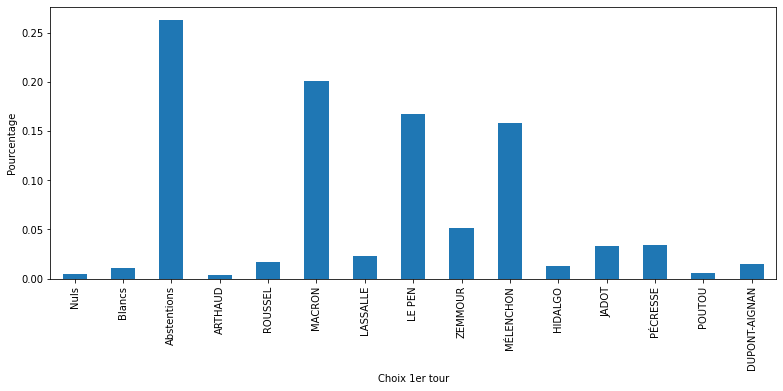

In [21]:
fig, ax = plt.subplots(figsize=(13, 5))
k = df_1.sum()/df_1.sum().sum()
ax = k.plot.bar(ax=ax)
ax.set_xlabel('Choix 1er tour')
ax.set_ylabel('Pourcentage');

On remarque :
 - le fort taux d'abstention qui a été observé au premier tour, 
 - ainsi que les deux candidats ("Macron", "Le Pen") qui se distinguent par le plus grand nombre de voix et qui sont sélectionnés pour le second tour.

#### Données du 2ème tour

Nous allons maintenant répéter la même opération pour les données obtenues au deuxième tour :

In [22]:
fname = '/tmp/T2.xlsx'

if not os.path.isfile(fname):
    url = 'https://static.data.gouv.fr/resources/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-2nd-tour/20220428-142301/resultats-par-niveau-burvot-t2-france-entiere.xlsx' # XLSX
    import urllib.request
    urllib.request.urlretrieve(url, fname)

T2 = pd.read_excel(fname)

T2.tail()

Code du département           Libellé du département  \
69677                  ZZ  Français établis hors de France   
69678                  ZZ  Français établis hors de France   
69679                  ZZ  Français établis hors de France   
69680                  ZZ  Français établis hors de France   
69681                  ZZ  Français établis hors de France   

       Code de la circonscription Libellé de la circonscription  \
69677                           6          6ème circonscription   
69678                          11         11ème circonscription   
69679                          11         11ème circonscription   
69680                           2          2ème circonscription   
69681                           2          2ème circonscription   

       Code de la commune Libellé de la commune Code du b.vote  Inscrits  \
69677                 229                Zurich           0001     24867   
69678                 231                Taipei           0001      1703   
69679                 233          Nour-Soultan           0001       117   
69680                 234             Monterrey           0001       715   
69681                 235      Bahamas (Nassau)           0001       137   

       Abstentions  % Abs/Ins  ...   Voix  % Voix/Ins  % Voix/Exp  \
69677        13153      52.89  ...  10166       40.88       88.88   
69678          928      54.49  ...    611       35.88       82.23   
69679           64      54.70  ...     39       33.33       78.00   
69680          510      71.33  ...    181       25.31       89.60   
69681           78      56.93  ...     35       25.55       68.63   

       Unnamed: 28  Unnamed: 29  Unnamed: 30  Unnamed: 31  Unnamed: 32  \
69677            2            F       LE PEN       Marine         1272   
69678            2            F       LE PEN       Marine          132   
69679            2            F       LE PEN       Marine           11   
69680            2            F       LE PEN       Marine           21   
69681            2            F       LE PEN       Marine           16   

       Unnamed: 33  Unnamed: 34  
69677         5.12        11.12  
69678         7.75        17.77  
69679         9.40        22.00  
69680         2.94        10.40  
69681        11.68        31.37  

[5 rows x 35 columns]

On vérifie que les données sont une nouvelle fois organisées suivant une structure similaire :

In [23]:
T2.columns

Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau', 'Sexe',
       'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34'],
      dtype='object')

In [24]:
T2.columns[:23]

Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau',
       'Sexe'],
      dtype='object')

In [25]:
T2.columns[23:]

Index(['Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34'],
      dtype='object')

In [26]:
T2.iloc[0, 23:]

Nom              MACRON
Prénom         Emmanuel
Voix                237
% Voix/Ins        36.86
% Voix/Exp        52.67
Unnamed: 28           2
Unnamed: 29           F
Unnamed: 30      LE PEN
Unnamed: 31      Marine
Unnamed: 32         213
Unnamed: 33       33.13
Unnamed: 34       47.33
Name: 0, dtype: object

In [27]:
col_start = 23
col_par_cdt = 7
candidats = T2.iloc[0][col_start::col_par_cdt]
candidats

Nom            MACRON
Unnamed: 30    LE PEN
Name: 0, dtype: object

Une fois cette vérification faite, nous pouvons extraire les données dans un nouveau tableau :

In [28]:
df_2 = T2[['Nuls', 'Blancs', 'Abstentions']].copy()
df_2.head()

Nuls  Blancs  Abstentions
0     5      42          146
1     3      23           45
2    22      71          322
3    18      45          313
4    21      87          303

Nous vérifions aussi que nous avons le même nombre de bureaux de vote :

In [29]:
len(df_2)

69682

In [30]:
for i_candidat, candidat in enumerate(candidats):
    i_col = col_start + i_candidat*col_par_cdt + 2
    print(i_col, T2.iloc[:, i_col].values)
    df_2[candidat] = T2.iloc[:, i_col].values

25 [237  94 360 ...  39 181  35]
32 [213  48 355 ...  11  21  16]


In [31]:
df_2

Nuls  Blancs  Abstentions  MACRON  LE PEN
0         5      42          146     237     213
1         3      23           45      94      48
2        22      71          322     360     355
3        18      45          313     426     327
4        21      87          303     449     353
...     ...     ...          ...     ...     ...
69677    49     227        13153   10166    1272
69678     6      26          928     611     132
69679     0       3           64      39      11
69680     1       2          510     181      21
69681     1       7           78      35      16

[69682 rows x 5 columns]

De la même façon que pour le premier tour, nous pouvons représenter les résultats totaux obtenus au second tour de façon graphique :

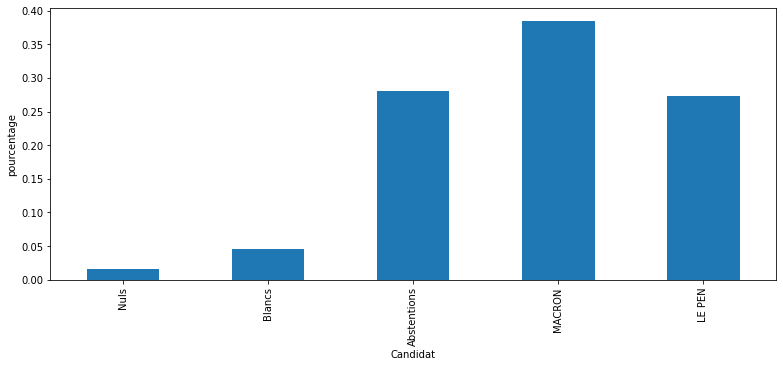

In [32]:
fig, ax = plt.subplots(figsize=(13, 5))
k = df_2.sum()/df_2.sum().sum()
ax = k.plot.bar(ax=ax)
ax.set_xlabel('Candidat')
#ax.set_xlim(1, 10)
#ax.set_xticks(np.arange(1, 10)+.5)
#ax.set_xticklabels(np.arange(1, 10)) , rotation=45
ax.set_ylabel('pourcentage');

On vérifie :
 - le fort taux d'abstention observé au second tour, 
 - le candidat "Macron" résolte le plus de suffrages exprimés (mais aussi au total).

In [33]:
# à décommenter si on veut tester des prédictions sur les choix exprimés 
# df_2 = df_2.drop(columns=['Nuls', 'Blancs']])
# df_2 = df_2.drop(columns=['Abstentions']) (en plus, sans les abstentions)

### Nettoyage des données (non aux nans)

Certains bureaux de vote n'ont pas de votants au premier ou au deuxieme. Ceci peut engendrer des problèmes numériques en générant des divisions par zéro, des `Not a Number (NaN)` dans le jargon informatique. Comme ceux-ci représentent un nombre très faible d'électeurs nous allons les ignorer par rapport au reste de la population.

Nous pouvons d'abord compter le nombre de bureaux de vote qui n'ont aucun suffrage enregistré:

In [34]:
(df_1.sum(axis=1)==0).sum(), (df_2.sum(axis=1)==0).sum()

(10, 11)

Nous pouvons "effacer" ces bureaux du vote en commençant par filtrer ceux qui n'ont aucun suffrage enregistré au premier tour :

In [35]:
df_2.drop(df_2.loc[df_1.sum(axis=1)==0].index, inplace=True)
df_1.drop(df_1.loc[df_1.sum(axis=1)==0].index, inplace=True)

In [36]:
(df_1.sum(axis=1)==0).sum(), (df_2.sum(axis=1)==0).sum()

(0, 2)

Et maintenant répéter la même procédure sur les bureaux de vote qui n'ont aucun suffrage enregistré au second tour :

In [37]:
df_1.drop(df_1.loc[df_2.sum(axis=1)==0].index, inplace=True)
df_2.drop(df_2.loc[df_2.sum(axis=1)==0].index, inplace=True)

In [38]:
(df_1.sum(axis=1)==0).sum(), (df_2.sum(axis=1)==0).sum()

(0, 0)

### Statistiques de second ordre

Comme cela est montré dans l'[article du Monde](https://www.lemonde.fr/les-decodeurs/article/2022/05/04/election-presidentielle-2022-quels-reports-de-voix-entre-les-deux-tours_6124672_4355770.html) on peut montrer la dépendance entre les choix qui sont effectués au premier tour et ceux qui sont effectués au deuxième tour. On va utiliser des représentations graphiques similaires à ceux de l'article pour d'une première part les répliquer et vérifier que la méthode est correct et d'un autre côté pour mieux comprendre comment nous pouvons tirer dans ses enseignements depuis ces observations.

In [39]:
df_12 = pd.DataFrame()

In [40]:
df_12['1_MÉLENCHON'] = df_1['MÉLENCHON'].copy()
df_12['MACRON'] = df_2['MACRON'].copy()

In [41]:
df_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69670 entries, 0 to 69681
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   1_MÉLENCHON  69670 non-null  int64
 1   MACRON       69670 non-null  int64
dtypes: int64(2)
memory usage: 1.6 MB


In [42]:
df_12['1_MÉLENCHON'] = df_12['1_MÉLENCHON']/df_1.sum(axis=1)
df_12['MACRON'] = df_12['MACRON']/df_2.sum(axis=1)

In [43]:
import seaborn as sns

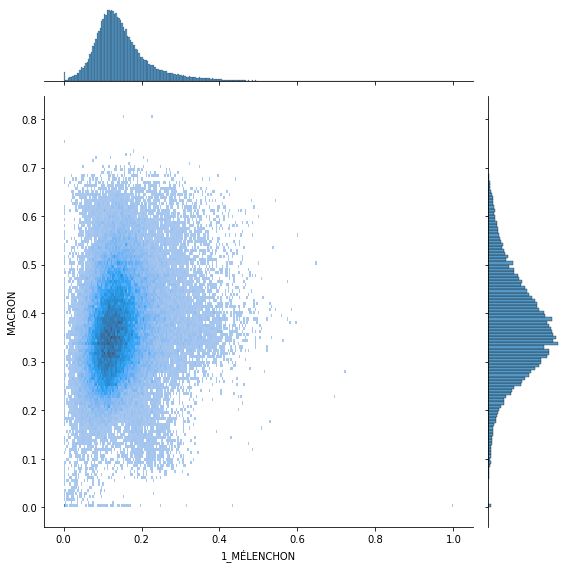

In [44]:
sns.jointplot(x=df_12['1_MÉLENCHON'], y=df_12['MACRON'], kind='hist', height=8);

On remarque effectivement une dépendance entre le choix. Un premier candidat effectué au premier tour et celui qui est effectué au second tour. Nous allons essayer d'inférer de façon plus précise cette dépendance grâce au modèle de transition que nous avons exposé au début de cet article.

Coté esthétique, on montre aussi :
 - qu'un nuage de points est souvent trompeur, car il donne trop "d'importance visuelle" aux points qui sont en dehors du gros de la distribution. Ici, nous avons utilisé un histogramme qui donne une "image" qui semble mieux équilibrée par rapport à l'ensemble des votes (ça reste subjectif, "dans l'œil de l'observateur"),
 - que la forme de "banane" est liée au gauchissement de certaines distributions des préférences (par exemple le fait que la statistique de premier ordre de "Mélenchon" soit plus "tassée" vers $0$).

## Modèle de prédiction du transfert des voix

Maintenant que nous avons récolté les données pour chacun des deux tours, et que nous avons une idée qu'il existe une dépendance entre les choix qui sont faits entre un tour et le suivant, nous allons pouvoir utiliser des librairies de l'apprentissage automatique (machine learning en anglais) pour pouvoir inférer le report de voix entre les deux tours : Pour cela nous allons utiliser un travail précédemment effectué appliqué à l'[exploration du comportement humain](https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html) ou alors pour [l'épidémiologie de la Covid](https://laurentperrinet.github.io/sciblog/posts/2020-10-10-fitting-covid-data.html).

### Formatage des données au format de la librairie `torch`

Pendant un aperçu des résultats au premier tour :

In [45]:
df_1.head()

Nuls  Blancs  Abstentions  ARTHAUD  ROUSSEL  MACRON  LASSALLE  LE PEN  \
0     1      16          108        3        6     150        18     149   
1     1       3           38        2        7      50        10      23   
2     5      18          266        4       30     159        24     237   
3     6      15          265        6       13     201        19     210   
4     8      10          246        8       18     229        28     227   

   ZEMMOUR  MÉLENCHON  HIDALGO  JADOT  PÉCRESSE  POUTOU  DUPONT-AIGNAN  
0       43         66        5     30        26       3             21  
1       14         41        3     10         8       3              0  
2       69        216       15     25        40       8             13  
3       68        194       19     46        42       4             20  
4       74        227       16     65        35       3             19

Nous avons donc comptabilisé ces différentes alternatives au premier tour :

In [46]:
len(df_1.columns)

15

De sorte que sur les bureaux de vote que nous avons validé nous avons les deux tableaux suivants :

In [47]:
df_1.values.shape, df_2.values.shape

((69670, 15), (69670, 5))

Nous allons maintenant utiliser la librairie `torch` pour enregistrer ses données sous la forme d'une matrice (ou *tenseur* dans le jargon de cette librairie) :

In [48]:
import torch

X_1, X_2 = df_1.values, df_2.values
x_1, x_2 = torch.Tensor(X_1), torch.Tensor(X_2)


In [49]:
x_1.shape

torch.Size([69670, 15])

Ainsi, nous allons très facilement pouvoir représenter les données pour pouvoir les apprendre. Une pratique extrêmement importante dans l'apprentissage automatique et de séparer les données qui sont utilisées pour apprendre le modèle (base d'apprentissage), avec celles qui sont utilisées pour tester ce modèle (base de test) :

In [50]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(x_1, x_2)

# Random split
train_set_size = int(len(dataset) * 0.9)
test_set_size = len(dataset) - train_set_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, test_set_size])

Ainsi nous pourrons utiliser l'ensemble d'apprentissage au cours des différentes époques d'apprentissage utilisé plus bas :

In [51]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [52]:
for n_1, n_2 in train_loader:
    break

Durant l'apprentissage, nous allons utiliser la méthode classique de « séparation par paquets ». Ceci consiste à séparer les données de façon aléatoire sous forme de différents « paquets » de bureaux de vote dont la taille est fixée ici à $32$. Nous vérifierons plus tard que si cette procédure permet d'accélérer l'apprentissage - la taille du paquet n'ayant qu'une influence sur la vitesse pour obtenir le résultat final (et non sur le résultat).

In [53]:
n_1.shape, n_2.shape

(torch.Size([32, 15]), torch.Size([32, 5]))

Dans chaque paquet (de bureaux de votes tirés au hasard sur la population française), nous pouvons compter le nombre de votes pour les différentes alternatives :

In [54]:
sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
sum_1, sum_2

(tensor([ 722.,   98., 1090.,  707.,  905.,  944.,  597., 1201.,  334.,  987.,
          652.,  134., 1153.,   38., 1398.,  793., 1018.,  840.,  263.,   64.,
         1067.,  572.,  355.,  912.,  735.,  733.,  748., 1073.,  335.,  536.,
          629., 1030.]),
 tensor([ 723.,   98., 1092.,  707.,  905.,  945.,  597., 1201.,  334.,  989.,
          653.,  134., 1153.,   38., 1396.,  793., 1018.,  840.,  263.,   64.,
         1069.,  572.,  355.,  912.,  737.,  733.,  749., 1075.,  335.,  536.,
          629., 1030.]))

Nous pouvons aussi vérifier que parmi toutes les alternatives, on peut calculer des fréquences d'occurrence, et que comme chaque individu peut faire un seul choix et un seul, la somme de ses fréquences d'occurrence pour chacun des paquets est égale à $1$.

In [55]:
(n_1/sum_1[:, None]).sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

Nous pourrons aussi aisément utiliser les données qui sont représentés dans l'ensemble de test :

In [56]:
n_1, n_2 = dataset[test_set.indices]
n_1.shape, n_2.shape

(torch.Size([6967, 15]), torch.Size([6967, 5]))

### Modèle `torch` de transition de probabilités


Maintenant que nous avons correctement formaté les données, nous allons exprimer dans le langage de la librairie `torch` le modèle qui nous permet d'exprimer la transition entre les préférences au premier tour et les préférences au premier second tour. En particulier, la matrice de transition sera définie par une matrice de poids `self.lin.weight`. Ces poids sont des valeurs réelles (sous format d'un `logit`) et sont utilisées  de telle sorte que la contrainte qui fait que la somme des éléments sur chaque ligne est bien égale à $1$ (grâce à l'utilisation de `torch.softmax(self.lin.weight, axis=1)` avant chaque codage) :

In [57]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F

torch.set_default_tensor_type("torch.FloatTensor")

class TransfertVoix(torch.nn.Module):
    def __init__(self, N_1er, N_2eme):#, device=None):
        super(TransfertVoix, self).__init__()
        self.lin = torch.nn.Linear(N_2eme, N_1er, bias=False)

    def forward(self, p_1):
        M = torch.softmax(self.lin.weight, axis=1)
        p_2_pred = torch.matmul(p_1, M)
        return p_2_pred

Ce modèle va utiliser comme dimension le nombre de différentes alternatives au premier et deuxième tour :

In [58]:
N_1er, N_2eme = len(df_1.columns), len(df_2.columns)
N_1er, N_2eme

(15, 5)

De telle sorte que nous allons pouvoir instancier un tel modèle, sachant que la matrice de transition sera initialement choisie de façon totalement aléatoire et donc déconnecté des données à la première époque de cet apprentissage :

In [59]:
trans = TransfertVoix(N_1er, N_2eme)

In [60]:
for p in trans.parameters():print(p)

Parameter containing:
tensor([[ 0.3532, -0.4249, -0.1104, -0.0098,  0.3663],
        [ 0.1314,  0.1393,  0.2407, -0.2820, -0.2106],
        [-0.1837, -0.2016, -0.3132,  0.4245,  0.1353],
        [ 0.1423,  0.0523,  0.2604, -0.2651, -0.1407],
        [-0.3224,  0.0649, -0.3304, -0.0631, -0.2614],
        [-0.2406,  0.1892,  0.2505, -0.2691, -0.2399],
        [-0.2697,  0.0210, -0.1019, -0.0457,  0.1510],
        [-0.3081, -0.1536, -0.2883, -0.0966, -0.1921],
        [-0.1968, -0.0381, -0.3438,  0.1664,  0.1303],
        [ 0.4051, -0.3519, -0.3098, -0.3335,  0.4097],
        [ 0.2001, -0.3427, -0.0740,  0.0525, -0.2990],
        [ 0.2742, -0.4451,  0.1304, -0.4326, -0.1397],
        [ 0.3331,  0.2803, -0.1192, -0.2880, -0.4419],
        [-0.3071, -0.2627,  0.2995, -0.0703, -0.1361],
        [-0.2800, -0.2266, -0.4155, -0.1032,  0.0963]], requires_grad=True)


In [61]:
trans.lin.weight.shape

torch.Size([15, 5])

In [62]:
torch.softmax(trans.lin.weight, axis=1)

tensor([[0.2634, 0.1210, 0.1657, 0.1832, 0.2668],
        [0.2225, 0.2242, 0.2482, 0.1471, 0.1580],
        [0.1646, 0.1617, 0.1446, 0.3025, 0.2265],
        [0.2243, 0.2050, 0.2524, 0.1492, 0.1690],
        [0.1717, 0.2529, 0.1703, 0.2225, 0.1825],
        [0.1628, 0.2502, 0.2660, 0.1582, 0.1629],
        [0.1589, 0.2125, 0.1879, 0.1988, 0.2420],
        [0.1803, 0.2105, 0.1839, 0.2228, 0.2025],
        [0.1706, 0.2000, 0.1473, 0.2454, 0.2367],
        [0.2906, 0.1363, 0.1422, 0.1389, 0.2920],
        [0.2624, 0.1525, 0.1995, 0.2264, 0.1593],
        [0.2851, 0.1389, 0.2469, 0.1406, 0.1885],
        [0.2791, 0.2648, 0.1776, 0.1500, 0.1286],
        [0.1579, 0.1651, 0.2896, 0.2001, 0.1873],
        [0.1793, 0.1891, 0.1565, 0.2139, 0.2612]], grad_fn=<SoftmaxBackward0>)

Nous vérifions que la contrainte sur chaque ligne de la matrice de transition et bien vérifiée :

In [63]:
torch.softmax(trans.lin.weight, axis=1).sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)

Exprimons maintenant pour chacun des bureaux de vote les probabilités de préférence qui sont exprimées localement :

In [64]:
sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
p_1 = n_1/sum_1[:, None]

Cette probabilité va pouvoir être multipliée par la matrice de transition de probabilité et nous vérifions dans les lignes suivantes la compatibilité entre les différentes dimensions des données représentées :

 - entrée (et sa somme sur les différents choix au 1er tour):

In [65]:
p_1.shape, p_1.sum(axis=1)

(torch.Size([6967, 15]),
 tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]))

 - transition:

In [66]:
trans.lin.weight.shape

torch.Size([15, 5])

 - sortie:

In [67]:
torch.matmul(p_1, torch.softmax(trans.lin.weight, axis=1)).shape

torch.Size([6967, 5])

Ces différentes vérifications nous permettent de valider l'utilisation directe du modèle pour prédire la probabilité de préférence dans ce bureau de vote au second tour à partir de celle observée au premier tour :

In [68]:
p_2_pred = trans(n_1/sum_1[:, None])
p_2_pred.mean(axis=0), p_2_pred.mean(axis=0).sum()

(tensor([0.1973, 0.1938, 0.1855, 0.2101, 0.2133], grad_fn=<MeanBackward1>),
 tensor(1., grad_fn=<SumBackward0>))

(Ce premier résultat est sûrement faux car les poids sont initialement fixés aléatoirement).

Au cours de l'apprentissage, nous allons pouvoir comparer cette probabilité prédit avec celle qui a été effectivement observée :

In [69]:
p_2 = n_2/sum_2[:, None]
p_2.mean(axis=0), p_2.mean(axis=0).sum()

(tensor([0.0189, 0.0505, 0.2536, 0.3714, 0.3057]), tensor(1.))

Nous allons aussi vérifier graphiquement que les résultats moyen des votes au second tour peuvent être inférer à partir des données de probabilité multiplié par la taille de chacun des bureaux de vote :

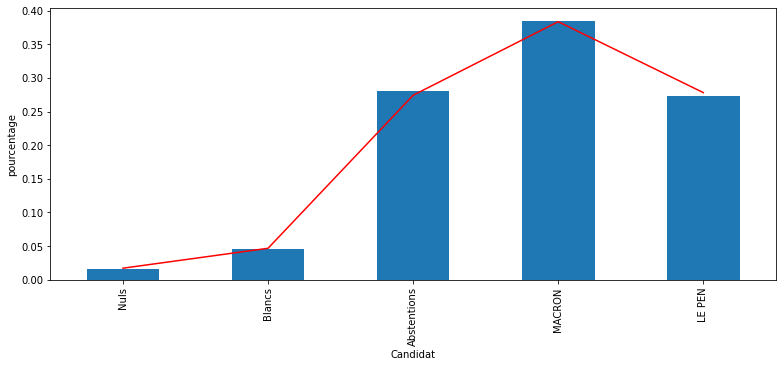

In [70]:
fig, ax = plt.subplots(figsize=(13, 5))
k = df_2.sum()/df_2.sum().sum()
ax = k.plot.bar(ax=ax)
p_2_average = (p_2*sum_2[:, None]).sum(axis=0)/sum_2.sum()
ax.plot(p_2_average, 'r')
ax.set_xlabel('Candidat')
ax.set_ylabel('pourcentage');

Ainsi que la concordance entre les résultats finaux obtenu est ce que nous représentons dans notre modèle :

In [71]:
k*100, p_2_average*100

(Nuls            1.651714
 Blancs          4.582147
 Abstentions    28.010677
 MACRON         38.497926
 LE PEN         27.257536
 dtype: float64,
 tensor([ 1.7085,  4.6699, 27.4290, 38.3725, 27.8200]))

In [72]:
F.binary_cross_entropy(p_2_average, p_2_average, reduction="sum")

tensor(2.1197)

### Modèle `torch` d'apprentissage

Maintenant que nous avons défini le modèle de transition des probabilités entre les préférences au premier tour et au second tour, nous pouvons maintenant écrire un algorithme d'apprentissage qui permet d'optimiser la concordance entre la prédiction et les observations. C'est donc un algorithme supervisé par les observations (sur les données de la base d'apprentissage) et que nous allons pouvoir tester sur la base de test.

Nous allons utiliser les distributions du second tour observées $q$ et prédites $\hat{q}$ (celle-ci dépendant de $M$) pour calculer un coût à minimiser
$$
\mathcal{L} =  KL(q, \hat{q})
$$

où la [divergence de Kullback-Leibler](https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler) entre deux distributions $P$ et $Q$ de support non-nul $k \in \Omega$ est calculée comme

$$
KL(P, Q) = \sum_{k \in \Omega} P_k \cdot \log \frac {P_k}{Q_k}
$$


Cette divergence est l'équivalent d'une distance dans les espaces de probabilité. Mathématiquement, c'est une semi-norme, car elle obéit à deux propriétés fondamentales : elle est toujours positive et est égale à zéro quand elle est appliquée à distributions identiques.

Pour généraliser cette méthode, nous allons aussi utiliser deux autres mesures et montrer ensuite que les résultats quantitatifs sont similaires :
- L1: la somme des valeurs absolues des différences entre les valeurs prédites et observées,
- BCE: la norme traditionnellement utilisée en régression multinomiale.

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [74]:
import torch.nn.functional as F

learning_rate = 10.0
beta1, beta2 = 0.99, 0
# beta1, beta2 = 0.9, 0.999 # décommenter pour utiliser Adam
num_epochs = 2 ** 5 + 1
num_epochs = 2 ** 10 + 1
batch_size = 256
do_optim = False
do_optim = True

def pdf_loss(p_pred, p, weight, loss_type):
    if loss_type=='kl':
        ind_nonzero = (p==0) + (p_pred==0)
        p[ind_nonzero] = 1.
        p_pred[ind_nonzero] = 1.
        kl_div = p * (p.log() - p_pred.log())
        loss_train = (kl_div * weight[:, None]).sum()
    elif loss_type=='l1':
        N_2eme = p.shape[1]
        div = torch.absolute(p - p_pred)
        loss_train = (div * weight[:, None]).sum() / N_2eme
    else: # BCE
        loss_train = F.binary_cross_entropy(p_pred, p, reduction="sum", weight=weight[:, None])
        loss_train -= F.binary_cross_entropy(p, p, reduction="sum", weight=weight[:, None])
    return loss_train

def fit_data(
    df_1,
    df_2,
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    loss_type='bce',
    beta1=beta1,
    beta2=beta2, 
    do_optim=do_optim, 
    split_ratio=.9, 
    seed=2022, # graine du générateur de nombre aléatoires utilisé dans le split test vs train
    verbose=False
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_1er, N_2eme = len(df_1.columns), len(df_2.columns)
    trans = TransfertVoix(N_1er, N_2eme)
    trans = trans.to(device)
    trans.train()

    # apprentissage
    if beta2==0: 
        optimizer = torch.optim.SGD(trans.parameters(), lr=learning_rate, momentum=beta1, nesterov=do_optim)
    else:
        optimizer = torch.optim.Adam(trans.parameters(), lr=learning_rate, betas=(beta1, beta2), amsgrad=do_optim)

    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # the data
    X_1, X_2 = df_1.values, df_2.values
    x_1, x_2 = torch.Tensor(X_1), torch.Tensor(X_2)

    # split train and test
    dataset = TensorDataset(x_1, x_2)
    train_set_size = int(len(dataset) * split_ratio)
    test_set_size = len(dataset) - train_set_size
    train_set, test_set = random_split(dataset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))
    train_loader = DataLoader(train_set, batch_size=int(batch_size), shuffle=True)

    n_1, n_2 = dataset[train_set.indices]
    sum_sum_2 = n_2.sum()

    for epoch in range(int(num_epochs)):
        losses = []
        for n_1, n_2 in train_loader:
            n_1, n_2 = n_1.to(device), n_2.to(device)

            sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
            p_1 = n_1/sum_1[:, None]
            p_2 = n_2/sum_2[:, None]

            p_2_pred = trans(p_1)
            weight = sum_2 / sum_sum_2 # donne un poids à chaque bureau de vote proportionnel à sa taille

            loss_train = pdf_loss(p_2_pred, p_2, weight, loss_type=loss_type)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            losses.append(loss_train.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} / {num_epochs} - Loss: {np.sum(losses):.5e}")

    loss_train = np.sum(losses) # somme des loss à la dernière époque
    loss_train = loss_train/split_ratio # normalise par rapport à la taille du train dataset

    # Test
    with torch.no_grad():
        n_1, n_2 = dataset[test_set.indices]
        sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
        p_2 = n_2/sum_2[:, None]
        p_1 = n_1/sum_1[:, None]
        p_2_pred = trans(p_1)
        weight = sum_2 / sum_2.sum() # normalise par rapport à la taille du dataset de test
        loss_test = pdf_loss(p_2_pred, p_2, weight, loss_type=loss_type)
        loss_test_l1 = pdf_loss(p_2_pred, p_2, weight, loss_type='l1')
        if verbose: print(f'Erreur ~ {loss_test_l1.item()*100:.1f}%')

    return trans, loss_train, loss_test, loss_test_l1, p_1.detach().numpy(), p_2.detach().numpy(), p_2_pred.detach().numpy()

## Résulats

### Convergence de l'apprentissage suivant plusieurs fonctions de coût

loss_type='l1'
Iteration: 0 / 1025 - Loss: 6.40975e-02
Iteration: 32 / 1025 - Loss: 1.63781e-02
Iteration: 64 / 1025 - Loss: 1.61895e-02
Iteration: 96 / 1025 - Loss: 1.61289e-02
Iteration: 128 / 1025 - Loss: 1.60956e-02
Iteration: 160 / 1025 - Loss: 1.60780e-02
Iteration: 192 / 1025 - Loss: 1.60647e-02
Iteration: 224 / 1025 - Loss: 1.60588e-02
Iteration: 256 / 1025 - Loss: 1.60487e-02
Iteration: 288 / 1025 - Loss: 1.60473e-02
Iteration: 320 / 1025 - Loss: 1.60419e-02
Iteration: 352 / 1025 - Loss: 1.60354e-02
Iteration: 384 / 1025 - Loss: 1.60370e-02
Iteration: 416 / 1025 - Loss: 1.60405e-02
Iteration: 448 / 1025 - Loss: 1.60306e-02
Iteration: 480 / 1025 - Loss: 1.60271e-02
Iteration: 512 / 1025 - Loss: 1.60262e-02
Iteration: 544 / 1025 - Loss: 1.60275e-02
Iteration: 576 / 1025 - Loss: 1.60279e-02
Iteration: 608 / 1025 - Loss: 1.60300e-02
Iteration: 640 / 1025 - Loss: 1.60278e-02
Iteration: 672 / 1025 - Loss: 1.60227e-02
Iteration: 704 / 1025 - Loss: 1.60187e-02
Iteration: 736 / 1025 - 

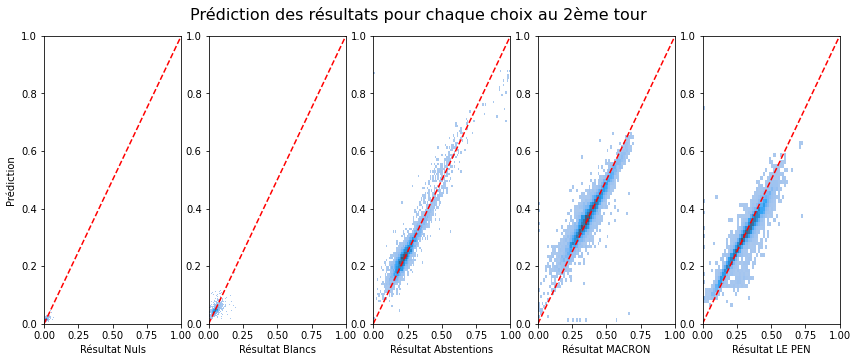

loss_type='kl'
Iteration: 0 / 1025 - Loss: 7.55288e-02
Iteration: 32 / 1025 - Loss: 1.11190e-02
Iteration: 64 / 1025 - Loss: 1.10002e-02
Iteration: 96 / 1025 - Loss: 1.09653e-02
Iteration: 128 / 1025 - Loss: 1.09267e-02
Iteration: 160 / 1025 - Loss: 1.09112e-02
Iteration: 192 / 1025 - Loss: 1.09057e-02
Iteration: 224 / 1025 - Loss: 1.08782e-02
Iteration: 256 / 1025 - Loss: 1.08378e-02
Iteration: 288 / 1025 - Loss: 1.08269e-02
Iteration: 320 / 1025 - Loss: 1.08161e-02
Iteration: 352 / 1025 - Loss: 1.08035e-02
Iteration: 384 / 1025 - Loss: 1.08113e-02
Iteration: 416 / 1025 - Loss: 1.08095e-02
Iteration: 448 / 1025 - Loss: 1.08075e-02
Iteration: 480 / 1025 - Loss: 1.08146e-02
Iteration: 512 / 1025 - Loss: 1.08062e-02
Iteration: 544 / 1025 - Loss: 1.08053e-02
Iteration: 576 / 1025 - Loss: 1.08002e-02
Iteration: 608 / 1025 - Loss: 1.07952e-02
Iteration: 640 / 1025 - Loss: 1.08064e-02
Iteration: 672 / 1025 - Loss: 1.07950e-02
Iteration: 704 / 1025 - Loss: 1.07948e-02
Iteration: 736 / 1025 - 

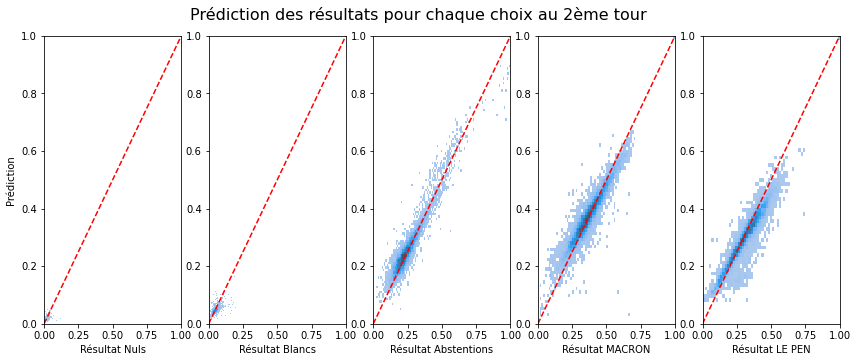

loss_type='bce'
Iteration: 0 / 1025 - Loss: 8.66346e-02
Iteration: 32 / 1025 - Loss: 1.44177e-02
Iteration: 64 / 1025 - Loss: 1.39880e-02
Iteration: 96 / 1025 - Loss: 1.36400e-02
Iteration: 128 / 1025 - Loss: 1.35635e-02
Iteration: 160 / 1025 - Loss: 1.35378e-02
Iteration: 192 / 1025 - Loss: 1.35256e-02
Iteration: 224 / 1025 - Loss: 1.35254e-02
Iteration: 256 / 1025 - Loss: 1.35203e-02
Iteration: 288 / 1025 - Loss: 1.35240e-02
Iteration: 320 / 1025 - Loss: 1.35519e-02
Iteration: 352 / 1025 - Loss: 1.34987e-02
Iteration: 384 / 1025 - Loss: 1.35054e-02
Iteration: 416 / 1025 - Loss: 1.34933e-02
Iteration: 448 / 1025 - Loss: 1.35059e-02
Iteration: 480 / 1025 - Loss: 1.34897e-02
Iteration: 512 / 1025 - Loss: 1.34902e-02
Iteration: 544 / 1025 - Loss: 1.34938e-02
Iteration: 576 / 1025 - Loss: 1.34798e-02
Iteration: 608 / 1025 - Loss: 1.34926e-02
Iteration: 640 / 1025 - Loss: 1.34872e-02
Iteration: 672 / 1025 - Loss: 1.35011e-02
Iteration: 704 / 1025 - Loss: 1.34880e-02
Iteration: 736 / 1025 -

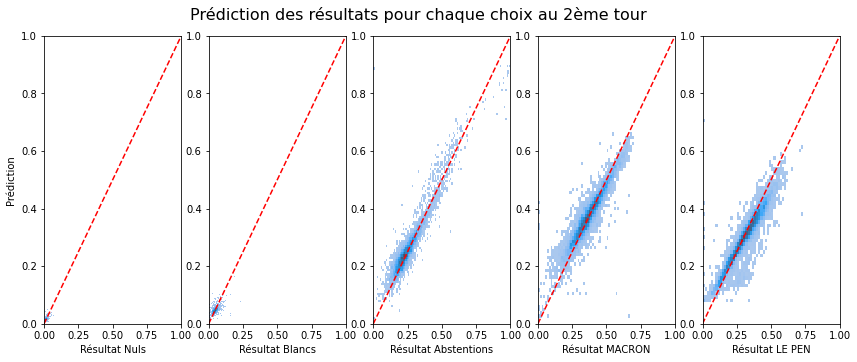

In [75]:
for loss_type in ['l1', 'kl', 'bce',]:
    print(f'{loss_type=}')
    trans, loss_train, loss_test, loss_test_l1, p_1, p_2, p_2_pred = fit_data(df_1, df_2, verbose=True, loss_type=loss_type)

    fig, axs = plt.subplots(1, N_2eme, figsize=(13, 5))
    for i_col, candidat in enumerate(df_2.columns):
        #axs[i_col].scatter(p_2[:,i_col], p_2_pred[:,i_col], alpha=.005)
        axs[i_col].plot([0, 1], [0, 1], 'r--')
        sns.histplot(x=p_2[:, i_col], y=p_2_pred[:, i_col], ax=axs[i_col])
        axs[i_col].set_xlabel("Résultat " + candidat)
        axs[i_col].set_xlim(0, 1)
        axs[i_col].set_ylim(0, 1)
    axs[0].set_ylabel("Prédiction ")
    plt.suptitle("Prédiction des résultats pour chaque choix au 2ème tour", fontsize=16)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9)
    plt.savefig(datetime + '_prediction_transfert-des-voix_' + loss_type +'.png');
    plt.show()


Ces graphiques représentent en abscisse les probabilités observées et en ordonnée les probabilités prédites. L'intérieur du graphique représente en niveaux de bleu l'histogramme des différentes valeurs telles qu'elles sont observés sur la base de test, c'est-à-dire sur $10\%$ de l'ensemble des bureaux de vote (tirés au hasard, environ $7000$).

On remarque de suite une prédiction très correcte des données du second tour à partir des observations du premier. Ceci montre la validité de notre hypothèse de transition, et aussi de son homognénéité dans le teritoire. On note aussi que les trois méthodes donnent sensiblement des résultats similaires et nous allons utiliser `bce` dans la suite.

Il faut noter que le nombre de paramètres libres de notre modèle est simplement celui de la matrice de transition stochastique soit $4 \times 15 = 60$.

Pour avoir une idée de l'erreur de prédiction, on peut estimer l'erreur absolue moyenne, c'est à dire la moyenne de l'écart observé sur la population:


In [76]:
print(f'Erreur ~ {loss_test_l1.item()*100:.1f}%')

Erreur ~ 1.7%


L'erreur est relativement faible (inférieure à 2 points de pourcentage) mais il faut garder en tête qu'elle présente des variations important par bureau de vote.

### analyse de le matrice de transition

On peut maintenant récupérer du modèle la matrice de transition qui a été inférée grâce a notre apprentissage automatique :

In [77]:
M = torch.softmax(trans.lin.weight, axis=1).detach().numpy()
M

array([[4.22462106e-01, 2.38107704e-02, 2.16653920e-03, 1.35150552e-01,
        4.16409969e-01],
       [1.25217410e-02, 6.02925777e-01, 1.24712114e-03, 1.87495118e-03,
        3.81430387e-01],
       [2.24835298e-06, 1.73289554e-05, 8.99260223e-01, 2.10442711e-02,
        7.96758831e-02],
       [2.90501952e-01, 1.25755202e-02, 1.87223486e-03, 2.31431494e-03,
        6.92735970e-01],
       [1.59886003e-01, 3.94331962e-01, 2.60606105e-03, 3.01951393e-02,
        4.12980825e-01],
       [2.01579169e-07, 1.28099327e-06, 3.69888876e-05, 9.99914289e-01,
        4.72215652e-05],
       [1.83704972e-01, 2.80349672e-01, 1.00350019e-03, 1.77587860e-03,
        5.33165932e-01],
       [6.18519664e-07, 1.03414561e-06, 1.90748451e-05, 1.76127705e-05,
        9.99961615e-01],
       [6.31992426e-03, 7.43023679e-02, 5.65578565e-02, 2.04505101e-01,
        6.58314824e-01],
       [1.83869135e-02, 7.29578361e-02, 2.77632922e-01, 6.03558481e-01,
        2.74639111e-02],
       [5.71057610e-02, 2.1459

On vérifie dans un premier temps que la contrainte est toujours bien respectée :

In [78]:
M.sum(axis=1), M.shape

(array([0.99999994, 0.99999994, 0.9999999 , 1.        , 0.9999999 ,
        0.99999994, 1.        , 0.99999994, 1.        , 1.        ,
        1.        , 0.99999994, 1.        , 1.        , 0.99999994],
       dtype=float32),
 (15, 5))

Une particularité de cette matrice (prédite sur l'ensemble des bureaux de votes) est que l'on peut maintenant s'en servir pour prédire la préférence au second tour en fonction de celle au premier.

En effet, si la préférence pour le choix d'un individu se pose au premier tour *entièrement* sur le choix $i^\ast$, on peut le formaliser comme $p_i = 0$ pour $i \neq i^\ast$ et $p_{i^\ast}=1$ et on obtient la prédiction:

$$
\hat{q}_j = M_{i^\ast j}
$$

En language commun, la préférence d'une personne votant $i^\ast$ au premier tour est la $i^\ast$-ième ligne de la matrice de transition (de taille $15 \times 5$ dans notre cas).

Nous allons nous inspirer d'[un graphique de la galerie matplotlib](https://matplotlib.org/stable/gallery/misc/table_demo.html#sphx-glr-gallery-misc-table-demo-py) pour représenter visuellement ces préférences de report de voix en fonction de chacun des choix éfféctués au premier tour :

In [79]:
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)
M*100

array([[ 42.2,   2.4,   0.2,  13.5,  41.6],
       [  1.3,  60.3,   0.1,   0.2,  38.1],
       [  0. ,   0. ,  89.9,   2.1,   8. ],
       [ 29.1,   1.3,   0.2,   0.2,  69.3],
       [ 16. ,  39.4,   0.3,   3. ,  41.3],
       [  0. ,   0. ,   0. , 100. ,   0. ],
       [ 18.4,  28. ,   0.1,   0.2,  53.3],
       [  0. ,   0. ,   0. ,   0. , 100. ],
       [  0.6,   7.4,   5.7,  20.5,  65.8],
       [  1.8,   7.3,  27.8,  60.4,   2.7],
       [  5.7,  21.5,   0.1,  72.5,   0.2],
       [  0. ,   0.1,   0. ,  99.9,   0. ],
       [  2.6,  12.6,   0.1,  84.6,   0.1],
       [ 17.1,  52.1,   0.5,   1.2,  29.2],
       [  1.8,   5.4,   0.1,   0.1,  92.5]], dtype=float32)

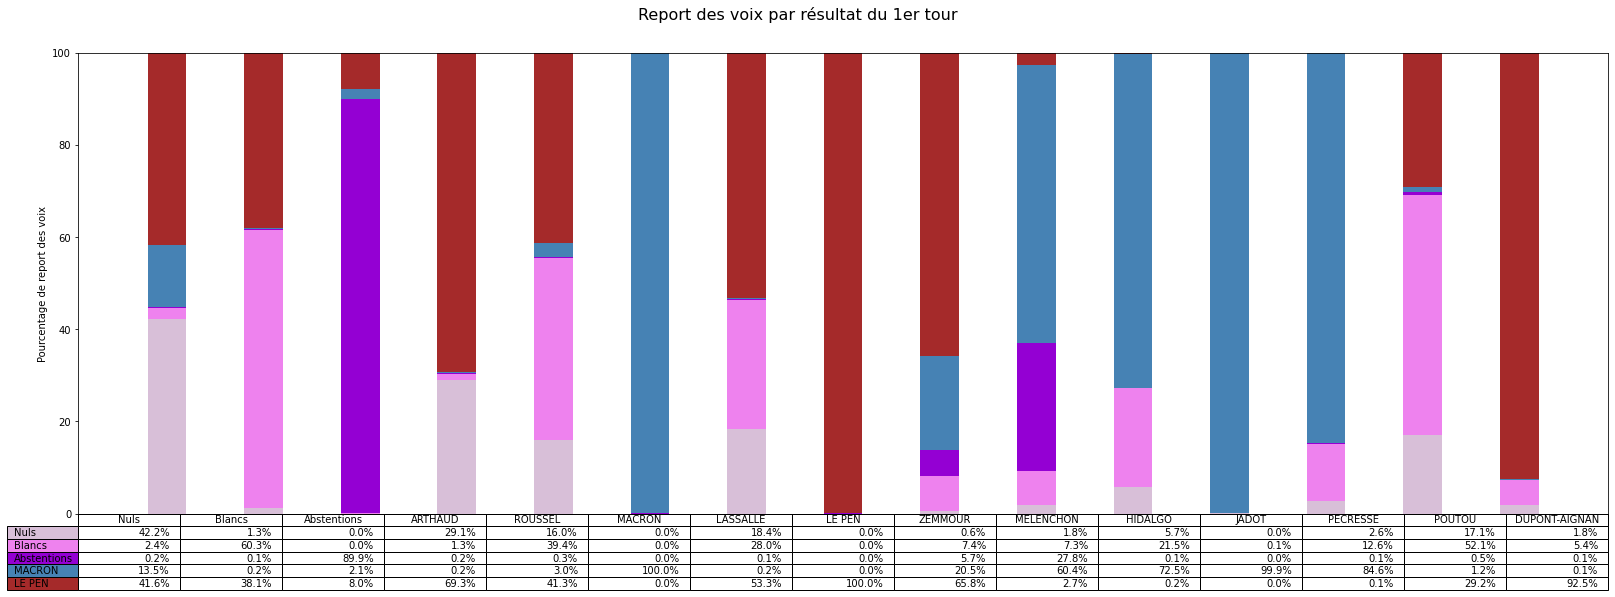

In [80]:
fig, ax = plt.subplots(figsize=(25, 8))

columns = df_1.columns
rows = df_2.columns

# named colors: https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ['thistle', 'violet', 'darkviolet', 'steelblue', 'brown' ]
n_rows = len(rows)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax.bar(index, M.T[row]*100, bar_width, bottom=y_offset, color=colors[row], linewidth=1)
    y_offset = y_offset + M.T[row]*100
    cell_text.append([f'{x*100:1.1f}%' for x in M.T[row]])
ax.set_ylim(0, 100)

# Add a table at the bottom of the axes
the_table = ax.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9)

plt.ylabel("Pourcentage de report des voix")
plt.yticks(np.linspace(0, 100, 6, endpoint=True))
plt.xticks([])
plt.suptitle("Report des voix par résultat du 1er tour", fontsize=16);

Ces données correspondent aux intuitions qu'on peut se faire quand au report des votes. Notamment on remarque que la plupart des individus qui s'abstiennent au premier tour se sont abstenus au second (avec une légère différence dans la proportion de "Mélenchon" qui se sont abstenus). Remarquez aussi que les électeurs de "Macron" ou "Le Pen" au premier tour ont massivement voté pour la même personne au deuxième tour ("vote d'adhésion"). Environ un quart des électeurs de "Le Pen" au second tour s'était abstenu au premier.

On observe aussi quelques points intéressants dans les votes nuls qui proviennent majoritairement de votant "nul" au premier tour ($40 \%$) et ensuite par des électeurs ayant voté pour des candidats marginaux au premier tour ("Arthaud", "Lassalle", "Roussel", "Poutou"). On observe à peu près la même structure pour le votant "blanc". On rappelle qu'en France, un vote nul est un bulletin qui n'a pas été validé, car il est par exemple raturé, alors qu'un vote blanc est exprimé par un bulletin de vote totalement blanc (et qu'il faut préparer en avance). On peut donc expliquer ces observations par rapport aux particularités du vote "militant" lié à ces candidats.


On peut aussi se restreindre aux votes exprimés :

In [81]:
shift = 3
MT = M[shift:, shift:].T
MT /= MT.sum(axis=0)
MT*100

array([[  0.3,   6.8, 100. ,   0.3,   0. ,  23.7,  95.6,  99.7, 100. ,
         99.8,   3.8,   0.1],
       [ 99.7,  93.2,   0. ,  99.7, 100. ,  76.3,   4.4,   0.3,   0. ,
          0.2,  96.2,  99.9]], dtype=float32)

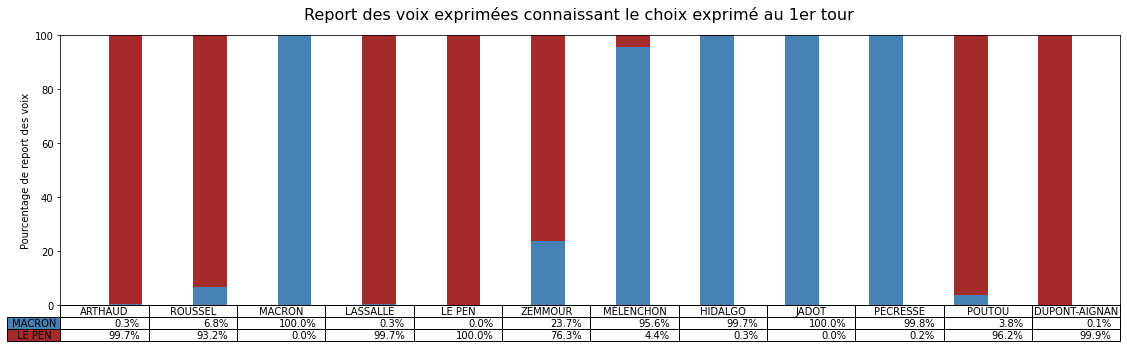

In [82]:
fig, ax = plt.subplots(figsize=(16, 5))

columns = df_1.columns[shift:]
rows = df_2.columns[shift:]

# named colors: https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ['steelblue', 'brown' ]
n_rows = len(rows)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax.bar(index, MT[row]*100, bar_width, bottom=y_offset, color=colors[row], linewidth=1)
    y_offset = y_offset + MT[row]*100
    cell_text.append([f'{x*100:1.1f}%' for x in MT[row]])
ax.set_ylim(0, 100)
# Add a table at the bottom of the axes
the_table = ax.table(cellText=cell_text, colLoc='center', 
                      rowLabels=rows, rowLoc='center',
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.05, bottom=0.15, right=0.97, top=.9)

plt.ylabel("Pourcentage de report des voix")
plt.yticks(np.linspace(0, 100, 6, endpoint=True))
plt.xticks([])
plt.suptitle("Report des voix exprimées connaissant le choix exprimé au 1er tour", fontsize=16)
plt.savefig(datetime + '_transfert-des-voix.png');

Ce tableau donne le pourcentage de chances d'exprimer une voix pour un candidat ou pour l'autre en fonction du choix qu'on a exprimé au premier tour. 

Ce tableau montre des tendances claires, par exemple que si on a voté "Macron", "Jadot", "Hidalgo" ou "Pécresse" au premier tour, alors on va certainement voter "Macron" au deuxième tour. Ces électeurs se montrent particulièrement consensuel et suivent le « pacte républicain » mise en place pour faire un "barrage" au Front National (en suivant le terme consacré). Il montre aussi que si on a voté "Le Pen" ou "Dupont-Aignan" au premier tour, alors on va voter Le Pen au deuxième, un clair vote de suivi.

Connaissant les couleurs politiques d'autres candidats du premier tour, on peut être surpris que les électeurs de "Arthaud", "Roussel", "Lassalle" ou "Poutou" ont majoritairement choisi "Le Pen" au deuxième tour, signifiant alors un rejet du candidat Macron. Les électeurs de Zemmour sont aussi partagés, signifiant un rejet des deux alternatives. **Ce résultat est à prendre avec des pincettes, car ces derniers candidats ont obtenu moins de votes et donc que le processus d'inférence est forcément moins précis parce qu'il y a moins de données disponibles.** 

Ces résultats permettent de placer les tendances pour chaque profil de choix du 1er tour en fonction des choix faits au second, un premier axe horizontal donnant la part des voix *exprimées* pour Macron, le deuxieme la part des voix exprimées. 

In [83]:
n_1 = df_1.sum()
n_1

Nuls               247151
Blancs             543609
Abstentions      12824156
ARTHAUD            197094
ROUSSEL            802422
MACRON            9783058
LASSALLE          1101387
LE PEN            8133828
ZEMMOUR           2485226
MÉLENCHON         7712520
HIDALGO            616478
JADOT             1627852
PÉCRESSE          1679001
POUTOU             268904
DUPONT-AIGNAN      725176
dtype: int64

0 Nuls
1 Blancs
2 Abstentions
3 ARTHAUD
4 ROUSSEL
5 MACRON
6 LASSALLE
7 LE PEN
8 ZEMMOUR
9 MÉLENCHON
10 HIDALGO
11 JADOT
12 PÉCRESSE
13 POUTOU
14 DUPONT-AIGNAN


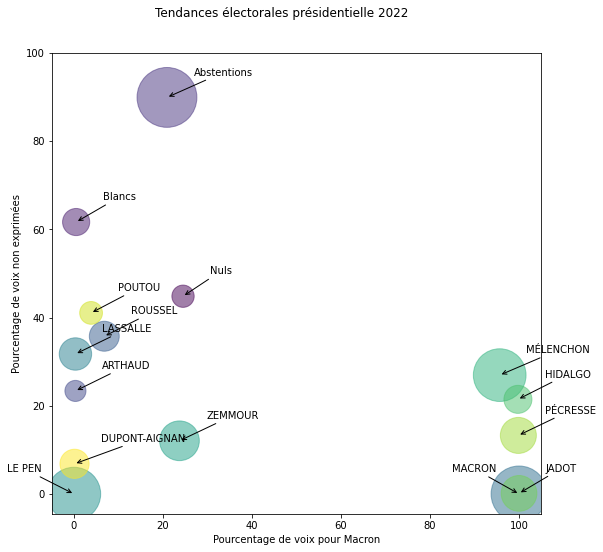

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))

p_nonexpr = M[:, :shift].sum(axis=1) / M.sum(axis=1)  * 100
p_macron = M[:, -2] / M[:, -2:].sum(axis=1) * 100
ax.scatter(p_macron, p_nonexpr, s=np.sqrt(n_1), c=np.arange(15), alpha=.5)

for i_column, column in enumerate(df_1.columns):
    print(i_column, column)
    textshift = -15 if ( (i_column ==5) or (i_column == 7)) else 6 
    ax.annotate(column,
            xy=(p_macron[i_column], p_nonexpr[i_column]), xycoords='data',
            xytext=(p_macron[i_column]+textshift, 
                    p_nonexpr[i_column]+5), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9)
# ax.set_xlim(0, 100)
# ax.set_ylim(0, 100)
plt.xlabel("Pourcentage de voix pour Macron")
plt.ylabel("Pourcentage de voix non exprimées")
plt.yticks(np.linspace(0, 100, 6, endpoint=True))
plt.xticks(np.linspace(0, 100, 6, endpoint=True))
plt.suptitle("Tendances électorales présidentielle 2022");
plt.savefig(datetime + '_transfert-des-voix_tendances.png');

Celà montre un paysage en trois groupes distincts dans cette présidentielle: les "abstentionnistes", les "extrèmes", les "républicains". Notons que ce résultat est nettement lié à la coalition lancée pour faire barrage à l'extrème droite et que les reports seront largement variables dans d'autres élections, comme des legislatives.

Pour se rendre compte de la variabilité des résultats qu'on obtient là, je conseille au lecteur (*à l'électeur*) de relancer ces notebook en utilisant différents « graines » pour le générateur de nombre aléatoire qui permet de séparer les données (le paramètre `seed`).

Muni de ces outils, on peut aussi faire certaines estimations (encore à prendre avec des pincettes) :

In [85]:
print(f"""
Total des voix au 1er tour= {x_1.sum():.0f}, dont Macron = {x_1[:, 5].sum():.0f} (soit une pourcentage de {x_1[:, 5].sum()/x_1.sum()*100:.2f}%), 
-> nombre de reports de Macron du 1er vers Le Pen au 2eme = {x_1[:, 5].sum()*MT[1, 2]:.0f} personnes.
""")


Total des voix au 1er tour= 48747860, dont Macron = 9783058 (soit une pourcentage de 20.07%), 
-> nombre de reports de Macron du 1er vers Le Pen au 2eme = 462 personnes.



À noter qu'on pourrait aussi utiliser une procédure similaire pour prédire pour un électeur du second tour la distribution des préférences au premier tour. En effet, si la préférence pour le choix d'un individu se pose au second tour *entièrement* sur le choix $j^\ast$, on peut le formaliser comme $q_j = 0$ pour $j \neq j^\ast$ et $q_{j^\ast}=1$ et on obtient la prédiction:

$$
\hat{q}_j = M^{+}_{j^\ast i}
$$

où $M^{+}$ est la pseudo-inverse de la matrice de transition.

### Influence des parametres

Finalement, et pour clore l'exercise, nous validons nos résultats en testant différentes paramétrisation de l'apprentissage et en donnant la valeur du loss calculé sur la base de test :

In [86]:
trans, loss_train_alt, loss_test_alt, loss_test_l1_alt, p_1, p_2, p_2_pred = fit_data(df_1, df_2, verbose=False, do_optim=not do_optim)
print(f'TRAIN: Loss avec {do_optim=} = {loss_train:.2e} / Loss avec alternative choice do_optim={not do_optim} = {loss_train_alt:.2e} ')
print(f'TEST: Loss avec {do_optim=} = {loss_test:.2e} / Loss avec alternative choice do_optim={not do_optim} = {loss_test_alt:.2e} ')

TRAIN: Loss avec do_optim=True = 1.50e-02 / Loss avec alternative choice do_optim=False = 1.50e-02 
TEST: Loss avec do_optim=True = 1.50e-02 / Loss avec alternative choice do_optim=False = 1.50e-02 


In [87]:
do_optim

True

Pour learning_rate= 1.00e+00, loss_train=1.51e-02 / loss_test=1.51e-02; le temps de calcul est 352.325 s
Pour learning_rate= 2.15e+00, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 367.290 s
Pour learning_rate= 4.64e+00, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 373.419 s
Pour learning_rate= 1.00e+01, loss_train=1.50e-02 / loss_test=1.51e-02; le temps de calcul est 362.251 s
Pour learning_rate= 2.15e+01, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 352.767 s
Pour learning_rate= 4.64e+01, loss_train=1.59e-02 / loss_test=1.65e-02; le temps de calcul est 351.497 s
Pour learning_rate= 1.00e+02, loss_train=1.60e-02 / loss_test=1.57e-02; le temps de calcul est 350.160 s


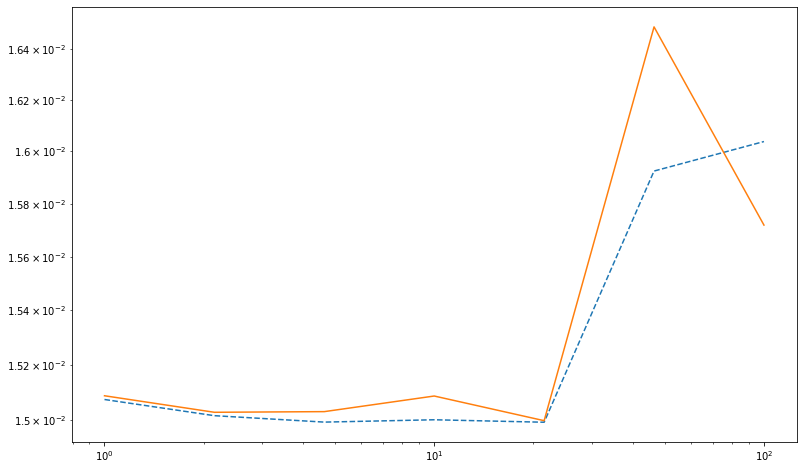

In [88]:
import time
N_scan = 7
results_train, results_test = [], []

learning_rates = learning_rate * np.logspace(-1, 1, 7, base=10)
for learning_rate_ in learning_rates:
    tic = time.time()
    trans, loss_train, loss_test, loss_test_l1, p_1, p_2, p_2_pred = fit_data(df_1, df_2, learning_rate=learning_rate_, num_epochs=num_epochs, verbose=False)
    print(f'Pour learning_rate= {learning_rate_:.2e}, {loss_train=:.2e} / {loss_test=:.2e}; le temps de calcul est {time.time()-tic:.3f} s')
    results_train.append(loss_train)
    results_test.append(loss_test)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(learning_rates, results_train, '--')
ax.plot(learning_rates, results_test)
ax.set_xlabel = 'learning rate'
ax.set_ylabel = 'Loss'
ax.set_yscale('log');
ax.set_xscale('log');

[  32  128  288  512  800 1152]
Pour batch_size= 32, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 758.352 s
Pour batch_size= 128, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 383.000 s
Pour batch_size= 288, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 335.277 s
Pour batch_size= 512, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 307.871 s
Pour batch_size= 800, loss_train=1.57e-02 / loss_test=1.57e-02; le temps de calcul est 365.565 s
Pour batch_size= 1152, loss_train=1.58e-02 / loss_test=1.58e-02; le temps de calcul est 355.077 s


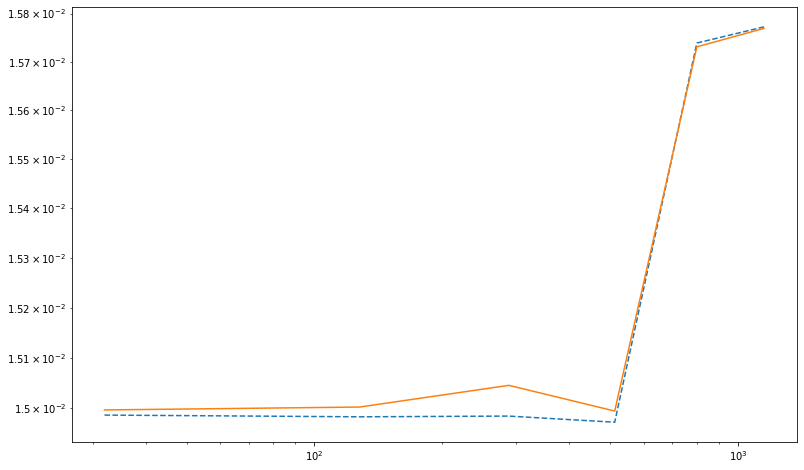

In [89]:
results_train, results_test = [], []
batch_sizes = (batch_size * np.arange(1, N_scan) ** 2) // 8
print(batch_sizes)
for batch_size_ in batch_sizes:
    tic = time.time()
    trans, loss_train, loss_test, loss_test_l1, p_1, p_2, p_2_pred = fit_data(df_1, df_2, batch_size=batch_size_, num_epochs=num_epochs, verbose=False)
    print(f'Pour batch_size= {batch_size_}, {loss_train=:.2e} / {loss_test=:.2e}; le temps de calcul est {time.time()-tic:.3f} s')
    results_train.append(loss_train)
    results_test.append(loss_test)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(batch_sizes, results_train, '--')
ax.plot(batch_sizes, results_test)
ax.set_xlabel = 'batch size'
ax.set_ylabel = 'Loss'
ax.set_yscale('log');
ax.set_xscale('log');

In [90]:
beta1s = 1 - (1 - beta1) * np.logspace(-1, 1, 7, base=10)
print(np.log10(beta1s))

[-0. -0. -0. -0. -0. -0. -0.]


[1.  1.  1.  1.  1.  1.  0.9]
Pour beta1= 9.99e-01, loss_train=1.67e-02 / loss_test=1.65e-02; le temps de calcul est 350.914 s
Pour beta1= 9.98e-01, loss_train=1.59e-02 / loss_test=1.60e-02; le temps de calcul est 345.636 s
Pour beta1= 9.95e-01, loss_train=1.58e-02 / loss_test=1.57e-02; le temps de calcul est 360.138 s
Pour beta1= 9.90e-01, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 365.451 s
Pour beta1= 9.78e-01, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 363.748 s
Pour beta1= 9.54e-01, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 364.457 s
Pour beta1= 9.00e-01, loss_train=1.51e-02 / loss_test=1.51e-02; le temps de calcul est 365.186 s


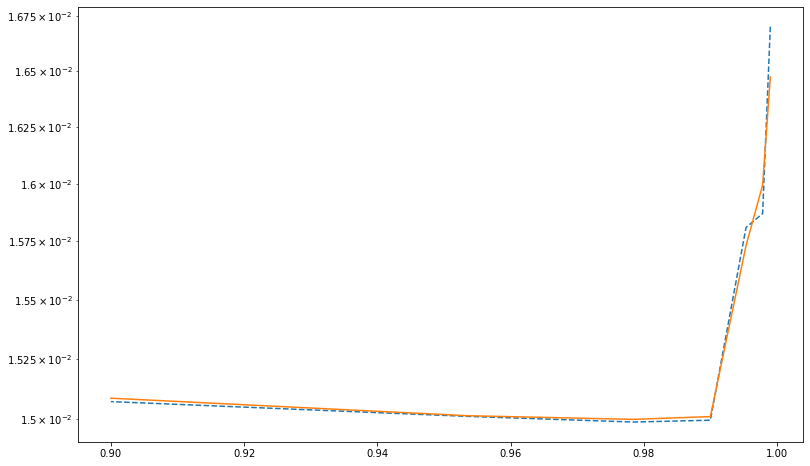

In [91]:
results_train, results_test = [], []
beta1s = 1 - (1 - beta1) * np.logspace(-1, 1, 7, base=10)
print(beta1s)
for beta1_ in beta1s:
    tic = time.time()
    trans, loss_train, loss_test, loss_test_l1, p_1, p_2, p_2_pred = fit_data(df_1, df_2, beta1=beta1_, num_epochs=num_epochs, verbose=False)
    print(f'Pour beta1= {beta1_:.2e}, {loss_train=:.2e} / {loss_test=:.2e}; le temps de calcul est {time.time()-tic:.3f} s')
    results_train.append(loss_train)
    results_test.append(loss_test)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(beta1s, results_train, '--')
ax.plot(beta1s, results_test)
ax.set_xlabel = 'beta1'
ax.set_ylabel = 'Loss';
ax.set_yscale('log');
#ax.set_xscale('log');

Pour beta2= 9.95e-01, loss_train=6.72e+00 / loss_test=6.12e+00; le temps de calcul est 377.528 s
Pour beta2= 9.89e-01, loss_train=6.81e+00 / loss_test=6.21e+00; le temps de calcul est 381.881 s
Pour beta2= 9.77e-01, loss_train=6.72e+00 / loss_test=6.13e+00; le temps de calcul est 387.187 s
Pour beta2= 9.50e-01, loss_train=6.74e+00 / loss_test=6.13e+00; le temps de calcul est 372.071 s
Pour beta2= 8.92e-01, loss_train=6.69e+00 / loss_test=6.09e+00; le temps de calcul est 380.279 s
Pour beta2= 7.68e-01, loss_train=6.69e+00 / loss_test=6.15e+00; le temps de calcul est 378.869 s
Pour beta2= 5.00e-01, loss_train=6.67e+00 / loss_test=6.06e+00; le temps de calcul est 397.812 s


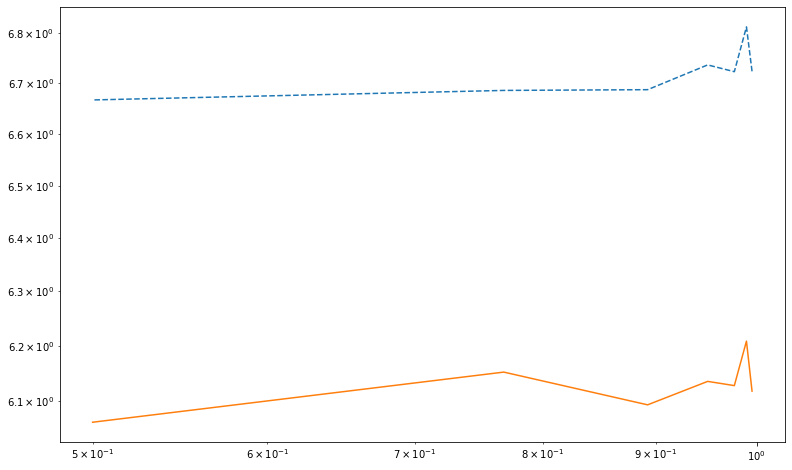

In [92]:
results_train, results_test = [], []
beta2s = 1 - (1 - .95) * np.logspace(-1, 1, 7, base=10)
for beta2_ in beta2s:
    tic = time.time()
    trans, loss_train, loss_test, loss_test_l1, p_1, p_2, p_2_pred = fit_data(df_1, df_2, beta2=beta2_, num_epochs=num_epochs, verbose=False)
    print(f'Pour beta2= {beta2_:.2e}, {loss_train=:.2e} / {loss_test=:.2e}; le temps de calcul est {time.time()-tic:.3f} s')
    results_train.append(loss_train)
    results_test.append(loss_test)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(beta2s, results_train, '--')
ax.plot(beta2s, results_test)
ax.set_xlabel = 'beta2 with Adam instead of SGD'
ax.set_ylabel = 'Loss'
ax.set_yscale('log');
ax.set_xscale('log');

[ 129  513 1153 2049 3201 4609]
Pour num_epochs=129, loss_train=1.51e-02 / loss_test=1.51e-02; le temps de calcul est 46.162 s
Pour num_epochs=513, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 183.287 s
Pour num_epochs=1153, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 415.698 s
Pour num_epochs=2049, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 732.785 s
Pour num_epochs=3201, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 1148.116 s
Pour num_epochs=4609, loss_train=1.50e-02 / loss_test=1.50e-02; le temps de calcul est 1634.783 s


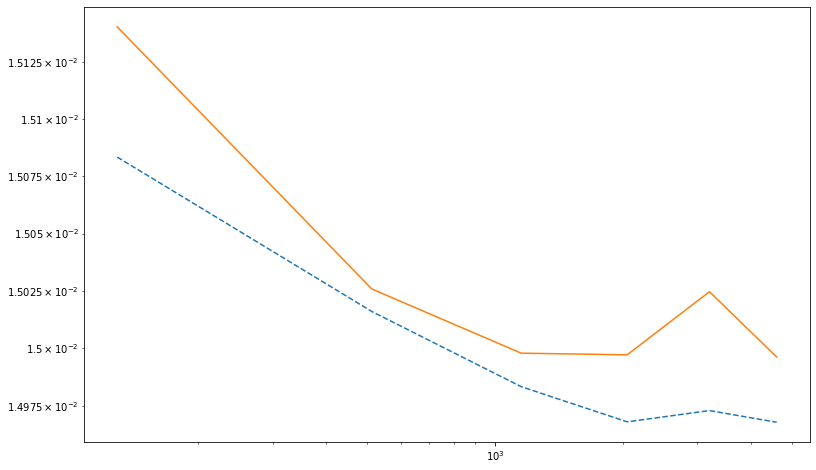

In [93]:
results_train, results_test = [], []
num_epochss = ((num_epochs-1) * np.arange(1, N_scan) ** 2) // 8 + 1
print(num_epochss)
for num_epochs_ in num_epochss:
    tic = time.time()
    trans, loss_train, loss_test, loss_test_l1, p_1, p_2, p_2_pred = fit_data(df_1, df_2, num_epochs=num_epochs_, verbose=False)
    print(f'Pour num_epochs={num_epochs_}, {loss_train=:.2e} / {loss_test=:.2e}; le temps de calcul est {time.time()-tic:.3f} s')
    results_train.append(loss_train)
    results_test.append(loss_test)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(num_epochss, results_train, '--')
ax.plot(num_epochss, results_test)
ax.set_xlabel = 'batch size'
ax.set_ylabel = 'Loss'
ax.set_yscale('log');
ax.set_xscale('log');